In [5]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from data_proccessing import valid_loader, train_loader, labels
from helper import train, evaluate, test
import os

In [6]:
num_classes = len(labels)  # Example number of classes

torch.manual_seed(43)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomAlexNet(nn.Module):
    def __init__(self):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of AlexNet
custom_alexnet = CustomAlexNet()
custom_alexnet.to(device)
print(custom_alexnet)

CustomAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): 

In [5]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import os

# class CustomAlexNet(nn.Module):
#     def __init__(self, num_classes):
#         super(CustomAlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

# # Set up directories and model
# # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# custom_alexnet = CustomAlexNet(num_classes).to(device)  # Adjust num_classes as necessary
# print(custom_alexnet)

In [8]:
# Clear CUDA memory
torch.cuda.empty_cache()

In [5]:
# Paths for saving
save_dir = "models/alexnet_variation_BCELoss"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# Define Params
criterion = nn.BCELoss()
num_epochs = 15
learning_rates = [0.001, 0.0005]
custom_alexnet.to(device)

# Track losses for visualization
train_losses_dict = {}
valid_losses_dict = {}

for lr in learning_rates:
    optimizer = optim.Adam(custom_alexnet.parameters(), lr=lr)

    best_valid_loss = float('inf')
    train_losses = []  
    valid_losses = []  

    for epoch in range(num_epochs):

        avg_train_loss = train(custom_alexnet, train_loader, optimizer, criterion, device)
        train_losses.append(avg_train_loss)
        
        valid_loss = evaluate(custom_alexnet, valid_loader, criterion, device)
        valid_losses.append(valid_loss)
        
        # Print validation loss
        print(f'Learning Rate: {lr}, Epoch: {epoch+1}, Test Loss: {avg_train_loss:.4f}, Validation Loss: {valid_loss:.4f}')
        
        # Save the best model if validation loss improves
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(custom_alexnet.state_dict(), os.path.join(save_dir, f'best_model_lr_{lr}.pt'))

    # Store losses for visualization
    train_losses_dict[lr] = train_losses
    valid_losses_dict[lr] = valid_losses

# Save losses dictionaries for visualization later
torch.save(train_losses_dict, os.path.join(save_dir, 'train_losses.pt'))
torch.save(valid_losses_dict, os.path.join(save_dir, 'valid_losses.pt'))

Learning Rate: 0.001, Epoch: 1, Test Loss: 0.4192, Validation Loss: 0.4054
Learning Rate: 0.001, Epoch: 2, Test Loss: 0.3862, Validation Loss: 0.3825
Learning Rate: 0.001, Epoch: 3, Test Loss: 0.3840, Validation Loss: 0.4482
Learning Rate: 0.001, Epoch: 4, Test Loss: 0.3793, Validation Loss: 0.3957
Learning Rate: 0.001, Epoch: 5, Test Loss: 0.3760, Validation Loss: 0.4000
Learning Rate: 0.001, Epoch: 6, Test Loss: 0.3722, Validation Loss: 0.3801
Learning Rate: 0.001, Epoch: 7, Test Loss: 0.3710, Validation Loss: 0.3690
Learning Rate: 0.001, Epoch: 8, Test Loss: 0.3704, Validation Loss: 0.3665
Learning Rate: 0.001, Epoch: 9, Test Loss: 0.3700, Validation Loss: 0.3644
Learning Rate: 0.001, Epoch: 10, Test Loss: 0.3693, Validation Loss: 0.3630
Learning Rate: 0.001, Epoch: 11, Test Loss: 0.3683, Validation Loss: 0.3606
Learning Rate: 0.001, Epoch: 12, Test Loss: 0.3686, Validation Loss: 0.3604
Learning Rate: 0.001, Epoch: 13, Test Loss: 0.3675, Validation Loss: 0.3617
Learning Rate: 0.001,

In [10]:
from data_proccessing import test_loader
from helper import test
import pandas as pd

save_dir = "models/alexnet_variation_BCELoss"
# Define Params
criterion = nn.BCELoss()
num_epochs = 15
custom_alexnet.to(device)

learning_rates = [0.001, 0.0005]
for lr in learning_rates:
    model_path = os.path.join(save_dir, f'best_model_lr_{lr}.pt')  # Change the filename accordingly
    custom_alexnet.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    metrics, loss = test(custom_alexnet, test_loader, criterion, device)


    print(metrics, loss)

    Precision  Accuracy  Recall  F1-score
0           0  0.811512     0.0         0
1           0  0.883747     0.0         0
2           0  0.878104     0.0         0
3           0  0.892777     0.0         0
4           0  0.762980     0.0         0
5           0  0.917607     0.0         0
6           0  0.898420     0.0         0
7           0  0.946953     0.0         0
8           0  0.713318     0.0         0
9           0  0.889391     0.0         0
10          0  0.932280     0.0         0
11          0  0.881490     0.0         0
12          0  0.879233     0.0         0
13          0  0.896163     0.0         0 0.36413839140108656
    Precision  Accuracy  Recall  F1-score
0           0  0.811512     0.0         0
1           0  0.883747     0.0         0
2           0  0.878104     0.0         0
3           0  0.892777     0.0         0
4           0  0.762980     0.0         0
5           0  0.917607     0.0         0
6           0  0.898420     0.0         0
7           0 

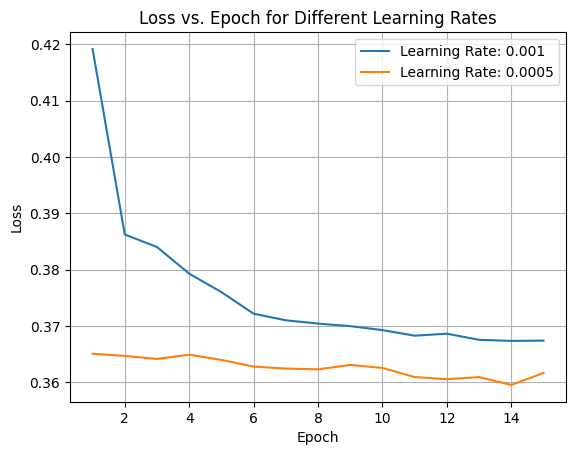

In [11]:
from helper import visualise_loss

save_dir = "models/alexnet_variation_BCELoss/"
model_path = os.path.join(save_dir, f'train_losses.pt')  # Change the filename accordingly
visualise_loss(model_path)

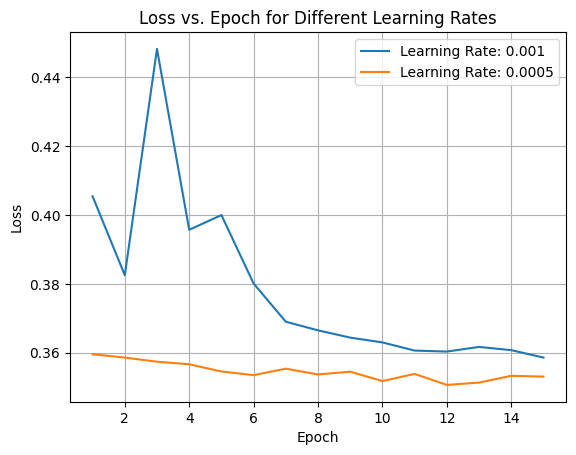

In [12]:
save_dir = "models/alexnet_variation_BCELoss/"
model_path = os.path.join(save_dir, f'valid_losses.pt')  # Change the filename accordingly
visualise_loss(model_path)